# **Exploratory Data Analysis 2 (EDA2) — Purpose & Scope**

This notebook focuses on **signal quality, interpretability, and fusion readiness** for the recommendation system.
Building on EDA1. 
analyses that directly guide **data science decisions** and **system tuning**.

**Objectives:**

* **Assess coverage & quality** of each representation:

  * TF-IDF
  * Semantic embeddings 
  * Authors
  * Numeric features
  * Image embeddings (optional)
* **Check feature diversity & agreement** to identify redundancy and confirm complementary signals.
* **Evaluate stability** of recommendations under small weight changes.
* **Visualize structure** of the data via UMAP and feature correlations.
* **Verify constraints** (max authors per recommendation, same description caps, era mismatch penalties).
* **Provide actionable insights** for weight tuning and feature retention/removal.

In [1]:
import logging, json, sys, os
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize

logging.basicConfig(level=logging.INFO)
ROOT = Path(os.getcwd()).parent
print(f"ROOT: {ROOT}")
sys.path.append(str(ROOT / "src"))
sys.path.append('..')

ROOT: c:\Users\User\Documents\book-recomendation


In [2]:
from src.clean.pipeline import clean_books_dataset
from src.features_representation.pipeline import fit_or_load_all
from src.recsys.utils import cosine_sim_dense, cosine_sim_csr, topk_indices_from_track, jaccard_at_k, kendall_tau_approx, umap_embed, nearest_table
from src.recsys.metrics import uniqueness_from_agreement, weight_scorecard, deltas_over_threshold, diversity_check
%pip install ipywidgets

ART = Path(ROOT / "artifacts/eda2") 
ART.mkdir(parents=True, exist_ok=True)
raw = pd.read_csv(ROOT / "data/raw/book.csv")
df = clean_books_dataset(raw, drop_language_col=True)
reps = fit_or_load_all(df, artifacts_root=ART)

N = len(df)
img_cov = float(reps.img_mask.mean()) if hasattr(reps, "img_mask") and reps.img_mask is not None else 0.0
use_img = img_cov >= 0.20 and hasattr(reps, "Z_img") and reps.Z_img is not None

manifest = {
    "rows": int(N),
    "non_en_pct": float(df["desc_suspected_non_english"].mean()*100),
    "covers_missing_pct": float((1.0 - img_cov)*100),
    "desc_groups": int(df["desc_hash"].nunique()),
    "desc_shared_pct": float(df["desc_is_shared"].mean()*100),
    "image_enabled": bool(use_img)
}
Path(ART, "run_manifest.json").write_text(json.dumps(manifest, indent=2), encoding="utf-8")
print(f"INSIGHT: loaded {N} rows; non-EN {manifest['non_en_pct']:.1f}%; image {'on' if use_img else 'off'}; shared desc {manifest['desc_shared_pct']:.1f}%")

INFO:src.clean.pipeline:Cleaning started. Input rows=4,766.


Note: you may need to restart the kernel to use updated packages.


INFO:src.clean.pipeline:Trimmed whitespace in title/authors/description.
INFO:src.clean.pipeline:Built author_list from authors.
INFO:src.clean.dedupe:Deduplicated by title + shared author. Removed 1 rows (0.02%).
INFO:src.clean.dedupe:  · 'salem s lot' merged 2 rows; years=[1975, 2005]
INFO:src.clean.pipeline:Dropped language_code column.
INFO:src.clean.pipeline:Trimmed disclaimer prefix through end marker for 6 rows.
INFO:src.clean.pipeline:Flagged suspected non-English: 29 rows (median strict-stopword=0.459 | median non-ascii=0.000)
INFO:src.clean.pipeline:Description grouping added: shared groups=157 (of 4765 rows).
INFO:src.clean.pipeline:Cleaning complete. Output rows=4,765. Columns=['book_id', 'authors', 'original_publication_year', 'title', 'average_rating', 'image_url', 'description', 'author_list', 'desc_suspected_non_english', 'desc_hash', 'desc_group_size', 'desc_is_shared'].
INFO:src.features_representation.lexical:TF‑IDF corpus built: rows=4765 | title_boost=2 | blanked_n

INSIGHT: loaded 4765 rows; non-EN 0.6%; image on; shared desc 3.3%


## Numeric features: variance and correlation (pre-normalization)

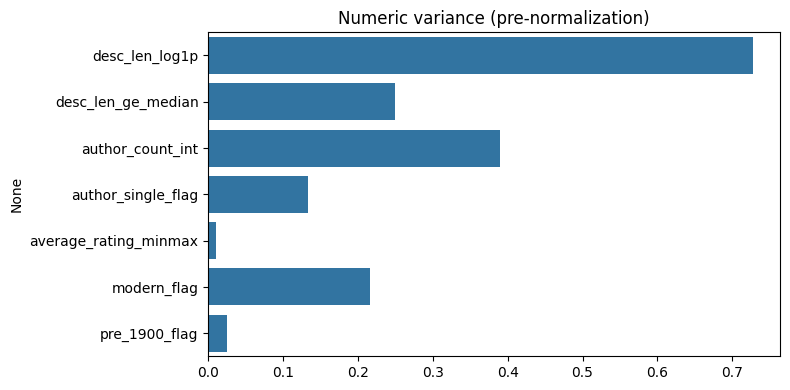

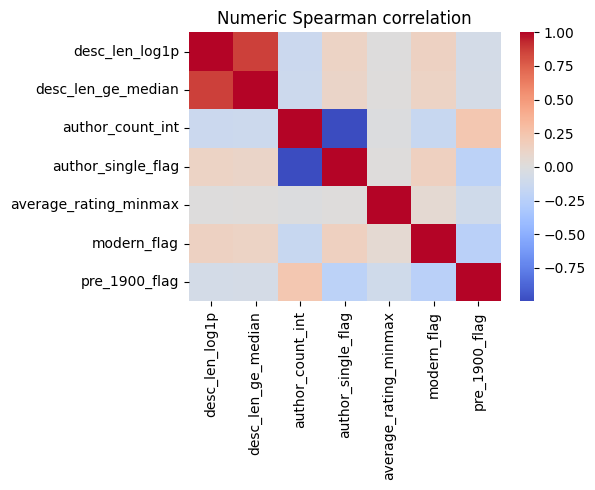

INSIGHT: low-variance numeric features: none


In [3]:
X_num_raw = reps.X_num_raw
num_cols = reps.num_feature_names
num_cols = [num for num in num_cols if num != "year_norm"]
X_num_raw = X_num_raw[:, [i for i, col in enumerate(reps.num_feature_names) if col != "year_norm"]]
num_df = pd.DataFrame(X_num_raw, columns=num_cols)

var_s = num_df.var(axis=0)
plt.figure(figsize=(8,4)); sns.barplot(x=var_s.values, y=var_s.index); plt.title("Numeric variance (pre-normalization)"); plt.tight_layout(); plt.show()

corr = num_df.corr(method="spearman")
plt.figure(figsize=(6,5)); sns.heatmap(corr, cmap="coolwarm", center=0); plt.title("Numeric Spearman correlation"); plt.tight_layout(); plt.show()

low_var = var_s[var_s < 1e-2].index.tolist()
pd.Series(low_var).to_csv(Path(ART, "numeric_low_variance.csv"), index=False, header=False)
print(f"INSIGHT: low-variance numeric features: {', '.join(low_var) if low_var else 'none'}")

## Authors: full distribution and IAF relationship

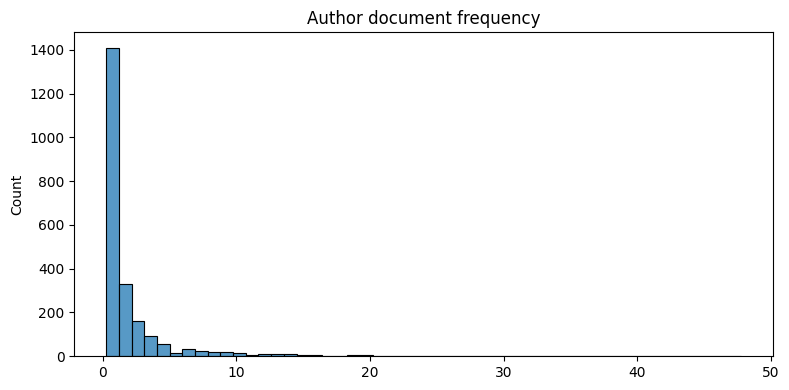

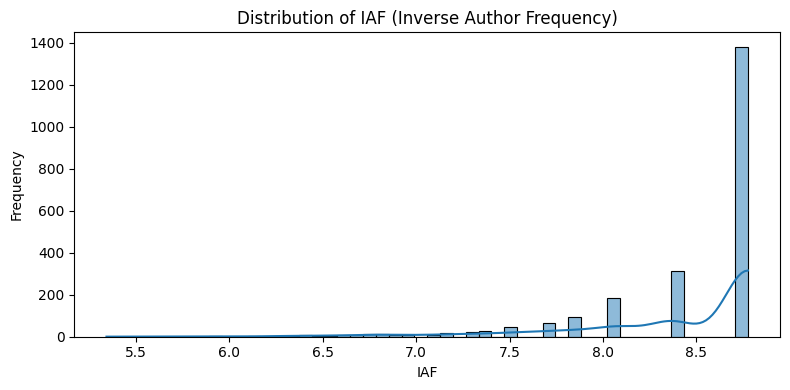

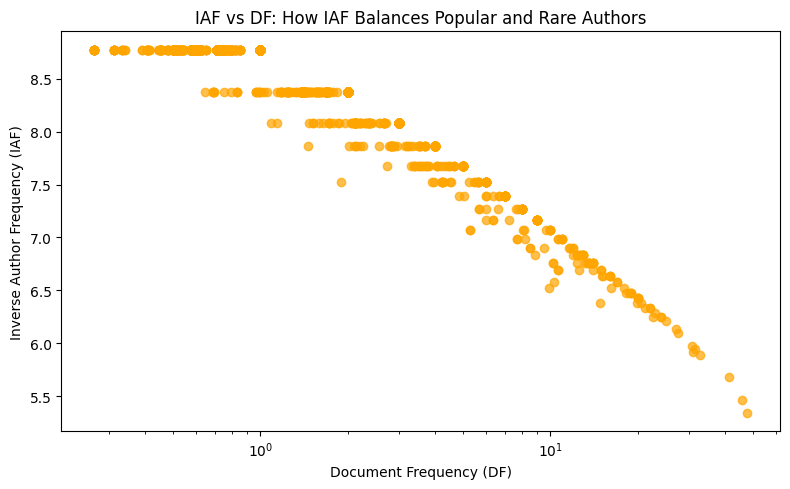

INSIGHT: author dominance >60% in top-10 occurs in 37.2% of books; cap same-author items in fusion if needed


In [4]:
X_auth = reps.X_auth
df_auth = np.array(X_auth.sum(axis=0)).ravel()
iaf = reps.authors_iaf

plt.figure(figsize=(8,4)); sns.histplot(df_auth, bins=50); plt.title("Author document frequency"); plt.tight_layout(); plt.show()
plt.figure(figsize=(8, 4)); sns.histplot(iaf, bins=50, kde=True); plt.title("Distribution of IAF (Inverse Author Frequency)"); plt.xlabel("IAF"); plt.ylabel("Frequency"); plt.tight_layout(); plt.show()
#plt.figure(figsize=(6,5)); plt.scatter(df_auth + 1e-9, iaf, s=10, alpha=0.6); plt.xscale("log"); plt.xlabel("DF"); plt.ylabel("IAF"); plt.title("DF vs IAF"); plt.tight_layout(); plt.show()
plt.figure(figsize=(8, 5)); plt.scatter(df_auth, iaf, alpha=0.7, c="orange"); plt.xscale("log"); plt.xlabel("Document Frequency (DF)"); plt.ylabel("Inverse Author Frequency (IAF)"); plt.title("IAF vs DF: How IAF Balances Popular and Rare Authors"); plt.tight_layout(); plt.show()

idx_auth10 = topk_indices_from_track(X_auth, 11)[:,1:]
author_sets = df["author_list"].apply(lambda xs: set(xs) if isinstance(xs, list) else set()).tolist()
dom = []
for i,row in enumerate(idx_auth10):
    base = author_sets[i]
    if not base:
        dom.append(False)
        continue
    shared = sum(1 for j in row if len(base.intersection(author_sets[j]))>0)
    dom.append(shared/10 > 0.60)
dom_share = float(np.mean(dom))
pd.DataFrame({"dominance_flag":dom}).to_csv(Path(ART, "authors_dominance_flags.csv"), index=False)
print(f"INSIGHT: author dominance >60% in top-10 occurs in {dom_share*100:.1f}% of books; cap same-author items in fusion if needed")

## TF‑IDF structure and sparsity

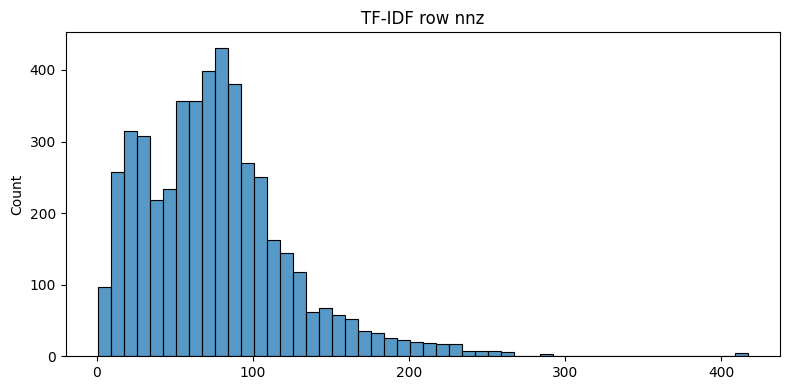

INSIGHT: TF-IDF ultra-sparse rows (<3 nnz): 0.3%
INFO: TF-IDF matrix is dense enough, no immediate action needed


In [5]:
X_tfidf = reps.X_tfidf
row_nnz = np.diff(X_tfidf.indptr)
plt.figure(figsize=(8,4)); sns.histplot(row_nnz, bins=50); plt.title("TF-IDF row nnz"); plt.tight_layout(); plt.show()

idf = reps.tfidf_vec.idf_
vocab_items = sorted(reps.tfidf_vec.vocabulary_.items(), key=lambda kv: kv[1])
vocab = np.array([w for w,_ in vocab_items])
top_idx = np.argsort(idf)[-20:]
bot_idx = np.argsort(idf)[:20]
pd.DataFrame({"top_idf_terms":vocab[top_idx]}).to_csv(Path(ART, "tfidf_high_idf_terms.csv"), index=False)
pd.DataFrame({"low_idf_terms":vocab[bot_idx]}).to_csv(Path(ART, "tfidf_low_idf_terms.csv"), index=False)
ultra_sparse = float((row_nnz < 3).mean())
print(f"INSIGHT: TF-IDF ultra-sparse rows (<3 nnz): {ultra_sparse*100:.1f}%")
if ultra_sparse > 0.50:
    print("WARNING: TF-IDF matrix is very sparse, consider using a different representation or thresholding")
if ultra_sparse < 0.05:
    print("INFO: TF-IDF matrix is dense enough, no immediate action needed")

## Embedding health and image gating

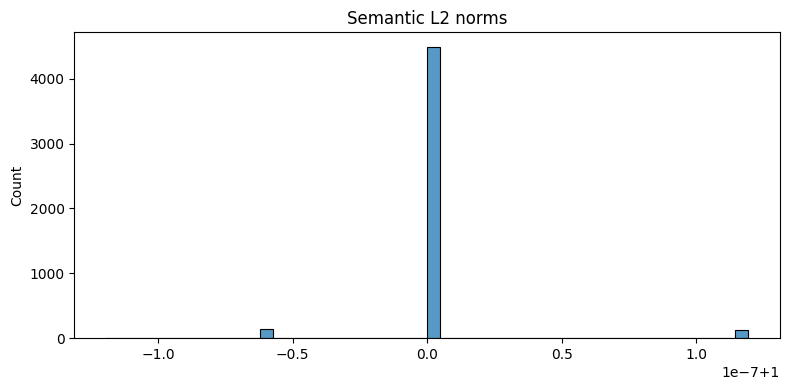

--- Semantic Embeddings ---
INSIGHT: semantic norms median 1.000, min_norm  1.000, max_norm  1.000
INSIGHT: Semantic embeddings look good! Median L2 norm is 1.000.


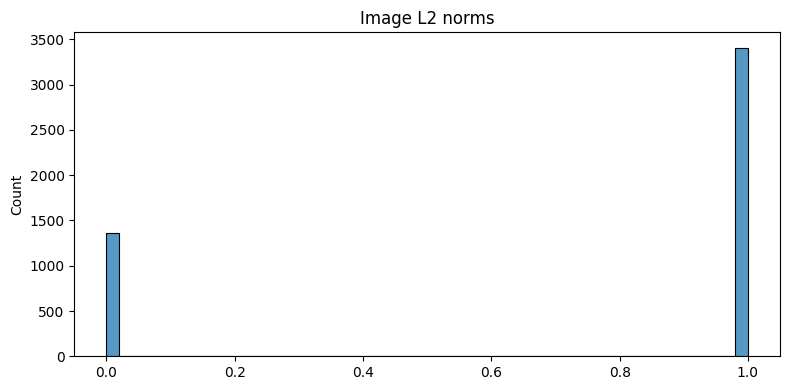


--- Image Embeddings ---
INSIGHT: image norms median 1.000, min_norm  0.000, max_norm  1.000


In [6]:
Z_sem = reps.Z_sem
sn = np.linalg.norm(Z_sem, axis=1)
plt.figure(figsize=(8,4)); sns.histplot(sn, bins=50); plt.title("Semantic L2 norms"); plt.tight_layout(); plt.show()

# --- Semantic Embeddings Analysis ---
median_norm_semantic = np.median(sn)
min_norm_semantic = np.min(sn)
max_norm_semantic = np.max(sn)
zero_count_semantic = np.sum(sn < 1e-3)

print("--- Semantic Embeddings ---")
print(f"INSIGHT: semantic norms median {median_norm_semantic:.3f}, min_norm {min_norm_semantic: .3f}, max_norm {max_norm_semantic: .3f}")
if median_norm_semantic > 0.5 and median_norm_semantic < 2.0 and zero_count_semantic < 0.05 * len(sn):
    print(f"INSIGHT: Semantic embeddings look good! Median L2 norm is {median_norm_semantic:.3f}.")
elif zero_count_semantic > 0.5 * len(sn):
    print(f"WARNING: Most semantic embeddings are near zero! {zero_count_semantic} out of {len(sn)}. This is a sign of a serious problem (model failure or data issue).")
elif np.any(sn < 0):
    print(f"WARNING: Some L2 norms are negative ({np.sum(sn < 0)} found). This should not happen. Check your embedding code for bugs.")
else:
    print(f"WARNING: Semantic embeddings may have issues. Median L2 norm is {median_norm_semantic:.3f}. Range: [{min_norm_semantic:.3f}, {max_norm_semantic:.3f}]. Check for inconsistencies.")

if use_img:
    Z_img = reps.Z_img
    inorm = np.linalg.norm(Z_img, axis=1)
    plt.figure(figsize=(8,4)); sns.histplot(inorm, bins=50); plt.title("Image L2 norms"); plt.tight_layout(); plt.show()
    
    median_norm_image = np.median(inorm)
    min_norm_image = np.min(inorm)
    max_norm_image = np.max(inorm)
    zero_count_image = np.sum(inorm < 1e-3)

    print("\n--- Image Embeddings ---")
    print(f"INSIGHT: image norms median {median_norm_image:.3f}, min_norm {min_norm_image: .3f}, max_norm {max_norm_image: .3f}")
    if median_norm_image > 0.5 and median_norm_image < 2.0 and zero_count_image < 0.05 * len(inorm):
        print(f"INSIGHT: Image embeddings look good! Median L2 norm is {median_norm_image:.3f}.")
    elif zero_count_image > 0.5 * len(inorm):
        print(f"WARNING: Most image embeddings are near zero! {zero_count_image} out of {len(inorm)}. This is a sign of a serious problem (model failure or data issue).")
    elif np.any(inorm < 0):
        print(f"WARNING: Some L2 norms are negative ({np.sum(inorm < 0)} found). This should not happen. Check your embedding code for bugs.")
    else:
        print(f"WARNING: Image embeddings may have issues. Median L2 norm is {median_norm_image:.3f}. Range: [{min_norm_image:.3f}, {max_norm_image:.3f}]. Check for inconsistencies.")
else:
    print("\nINFO: Image embeddings are not used.")

## Cross‑modality agreement@k and rank correlation

In [7]:
def pair_agree(a,b):
    j10 = float(jaccard_at_k(a[:,:10], b[:,:10]).mean())
    t10 = float(kendall_tau_approx(a[:,:10], b[:,:10]).mean())
    return j10, t10

idx_sem_100 = topk_indices_from_track(Z_sem, 100)
idx_tfidf_100 = topk_indices_from_track(X_tfidf, 100)
idx_auth_100 = topk_indices_from_track(X_auth, 100)
idx_num_100 = topk_indices_from_track(reps.X_num, 100)
idx_img_100 = topk_indices_from_track(reps.Z_img, 100) if use_img else None

pairs = {}
pairs["semantic_tfidf"] = pair_agree(idx_sem_100, idx_tfidf_100)
pairs["semantic_authors"] = pair_agree(idx_sem_100, idx_auth_100)
pairs["semantic_numeric"] = pair_agree(idx_sem_100, idx_num_100)
pairs["tfidf_authors"] = pair_agree(idx_tfidf_100, idx_auth_100)
pairs["tfidf_numeric"] = pair_agree(idx_tfidf_100, idx_num_100)
pairs["authors_numeric"] = pair_agree(idx_auth_100, idx_num_100)
if idx_img_100 is not None:
    pairs["semantic_image"] = pair_agree(idx_sem_100, idx_img_100)

agree_df = pd.DataFrame([(k,v[0],v[1]) for k,v in pairs.items()], columns=["pair","jaccard@10","kendall_tau@10"])
agree_df.to_csv(Path(ART, "modality_agreement.csv"), index=False)
print("INSIGHT: " + " | ".join([f"{r['pair']}: J@10={r['jaccard@10']:.2f}, τ@10={r['kendall_tau@10']:.2f}" for _,r in agree_df.iterrows()]))

GOOD_JACCARD_MIN = 0.25
GOOD_JACCARD_MAX = 0.8
GOOD_KENDALL_MIN = 0.15
GOOD_KENDALL_MAX = 0.7

for _, row in agree_df.iterrows():
    pair = row['pair']
    jaccard = row['jaccard@10']
    kendall_tau = row['kendall_tau@10']
    if (GOOD_JACCARD_MIN <= jaccard <= GOOD_JACCARD_MAX) and \
       (GOOD_KENDALL_MIN <= kendall_tau <= GOOD_KENDALL_MAX):
        print(f"INFO: Good agreement for pair '{pair}'. J@10={jaccard:.2f}, τ@10={kendall_tau:.2f}.")
    if jaccard < GOOD_JACCARD_MIN:
        print(f"WARNING: low Jaccard agreement for pair '{pair}'. J@10={jaccard:.2f}. Consider adjusting fusion weights or thresholds.")
    if kendall_tau < GOOD_KENDALL_MIN:
        print(f"WARNING: low Kendall's tau for pair '{pair}'. τ@10={kendall_tau:.2f}. Consider adjusting fusion weights or thresholds.")
    if jaccard > GOOD_JACCARD_MAX:
        print(f"WARNING: very high Jaccard agreement for pair '{pair}'. J@10={jaccard:.2f}. Consider adjusting fusion weights to avoid redundancy.")
    if kendall_tau > GOOD_KENDALL_MAX:
        print(f"WARNING: very high Kendall's tau for pair '{pair}'. τ@10={kendall_tau:.2f}. Consider adjusting fusion weights to avoid redundancy.")

INSIGHT: semantic_tfidf: J@10=0.31, τ@10=0.22 | semantic_authors: J@10=0.23, τ@10=-0.01 | semantic_numeric: J@10=0.02, τ@10=0.01 | tfidf_authors: J@10=0.26, τ@10=0.00 | tfidf_numeric: J@10=0.02, τ@10=0.00 | authors_numeric: J@10=0.01, τ@10=-0.01 | semantic_image: J@10=0.03, τ@10=0.01
INFO: Good agreement for pair 'semantic_tfidf'. J@10=0.31, τ@10=0.22.


## UMAP structure and stability grid (n_neighbors ∈ {10,25})

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP n_neighbors=4 - TF-IDF clusters: True, Semantic clusters: True


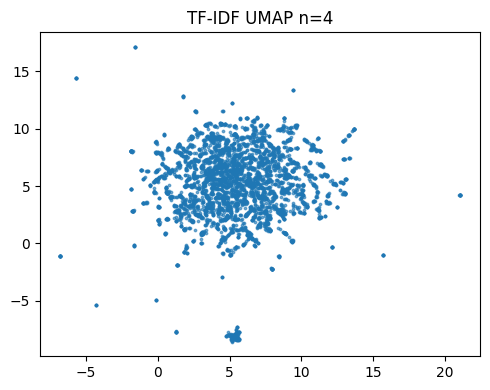

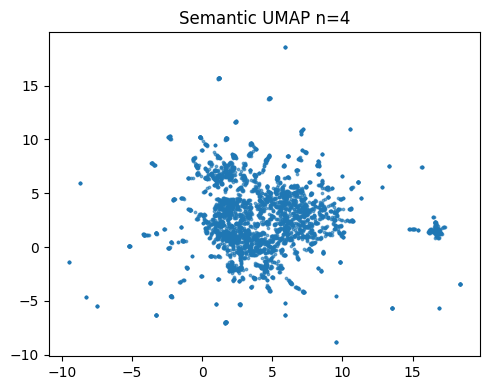

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP n_neighbors=5 - TF-IDF clusters: True, Semantic clusters: True


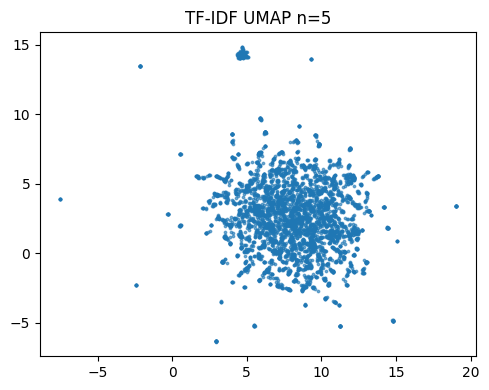

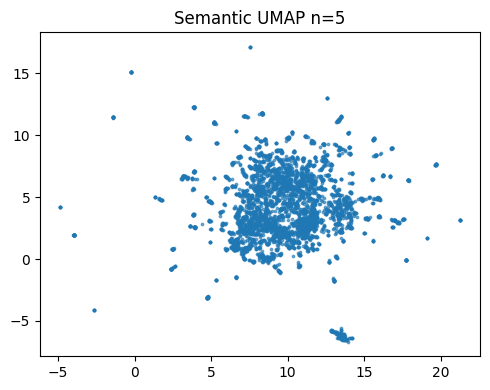

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP n_neighbors=7 - TF-IDF clusters: True, Semantic clusters: True


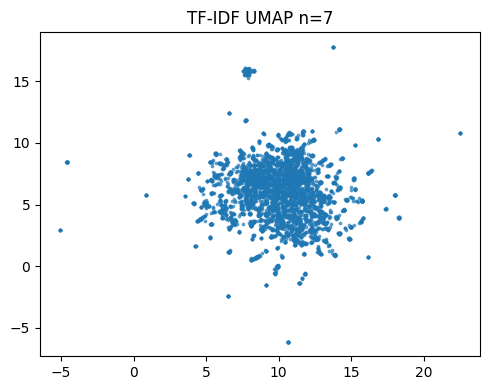

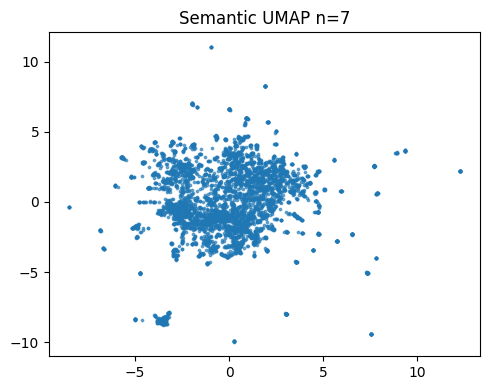

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP n_neighbors=10 - TF-IDF clusters: True, Semantic clusters: True


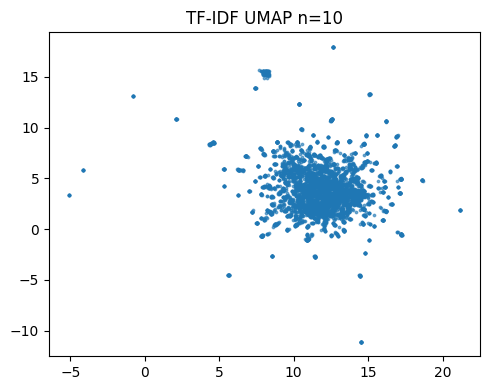

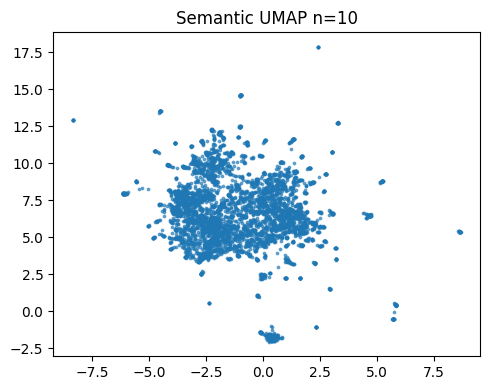

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP n_neighbors=20 - TF-IDF clusters: True, Semantic clusters: True


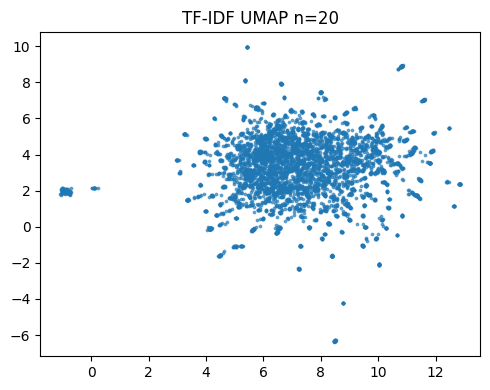

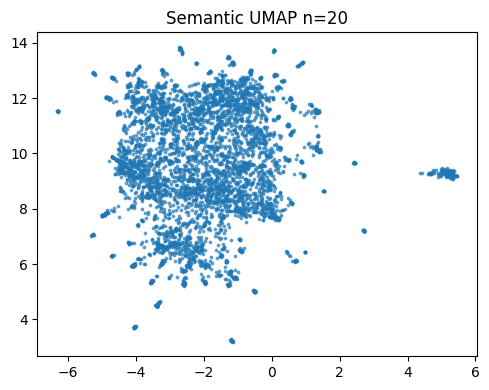

INSIGHT: prefer the modality with clearer clusters for content weight


In [ ]:
for nn in [25]:
    emb_tf = umap_embed(X_tfidf, n_neighbors=nn, random_state=42)
    emb_sm = umap_embed(Z_sem, n_neighbors=nn, random_state=42)
    is_there_clusters_tf = np.any(np.diff(np.sort(emb_tf[:,0])) > 0.2) and np.any(np.diff(np.sort(emb_tf[:,1])) > 0.2)
    is_there_clusters_sm = np.any(np.diff(np.sort(emb_sm[:,0])) > 0.2) and np.any(np.diff(np.sort(emb_sm[:,1])) > 0.2)
    if is_there_clusters_tf or is_there_clusters_sm:
        print(f"UMAP n_neighbors={nn} - TF-IDF clusters: {is_there_clusters_tf}, Semantic clusters: {is_there_clusters_sm}")
        plt.figure(figsize=(5,4)); plt.scatter(emb_tf[:,0], emb_tf[:,1], s=3, alpha=0.6); plt.title(f"TF-IDF UMAP n={nn}"); plt.tight_layout(); plt.show()
        plt.figure(figsize=(5,4)); plt.scatter(emb_sm[:,0], emb_sm[:,1], s=3, alpha=0.6); plt.title(f"Semantic UMAP n={nn}"); plt.tight_layout(); plt.show()
        
print("INSIGHT: prefer the modality with clearer clusters for content weight")



## Positive/negative separation (fusion readiness)

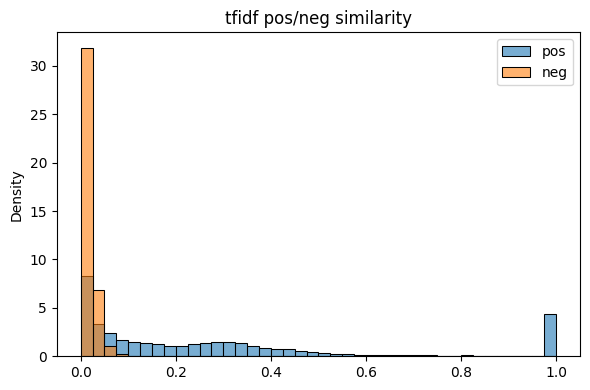

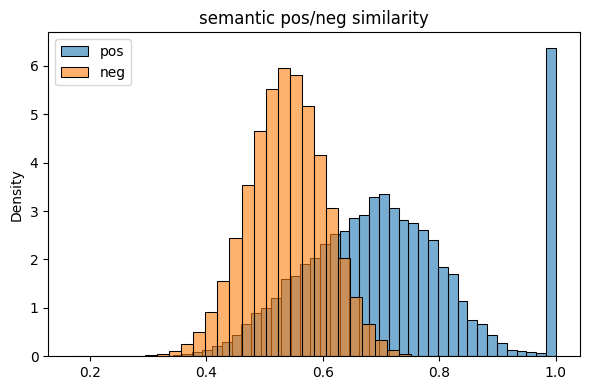

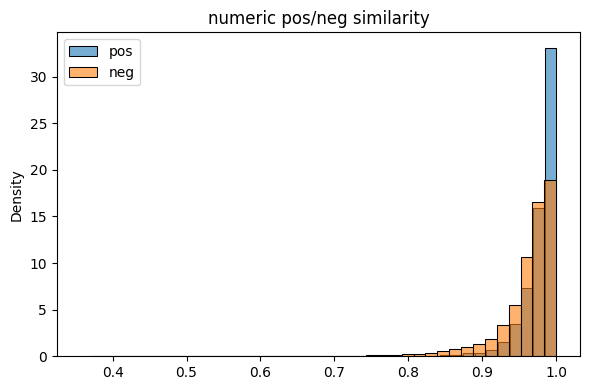

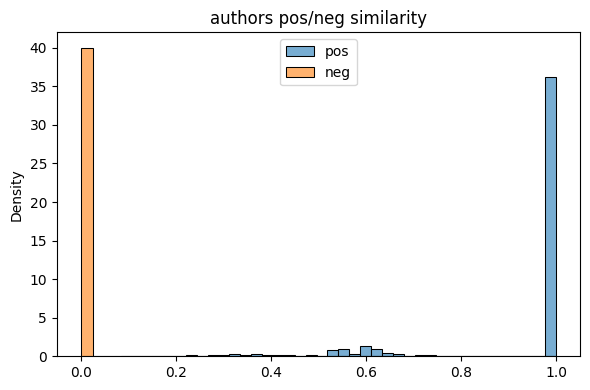

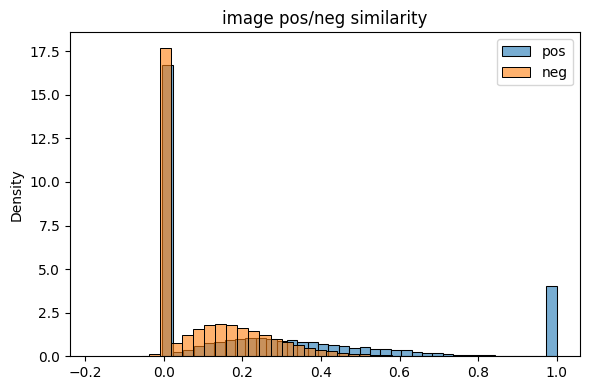

INSIGHT: tfidf=0.72, semantic=0.66, numeric=0.25, authors=1.00, image=0.29


In [9]:
main_author = df["author_list"].apply(lambda xs: xs[0].strip().lower() if isinstance(xs,list) and len(xs)>0 else "").values
same_author = (main_author[:,None] == main_author[None,:])
pos_mask = same_author
neg_mask = ~pos_mask

modalities = {
    "tfidf": X_tfidf,
    "semantic": Z_sem,
    "numeric": reps.X_num,
    "authors": X_auth
}
if use_img:
    modalities["image"] = reps.Z_img

sep = {}
for name, M in modalities.items():
    if hasattr(M, "toarray"):
        S = cosine_sim_csr(M).toarray()
    else:
        S = cosine_sim_dense(M, M)
    p = S[pos_mask]
    q = S[neg_mask]
    thr = np.percentile(q, 95)
    score = float((p > thr).mean()) if len(p)>0 and len(q)>0 else 0.5
    sep[name] = score
    plt.figure(figsize=(6,4)); sns.histplot(p, bins=40, stat="density", alpha=0.6, label="pos"); sns.histplot(q, bins=40, stat="density", alpha=0.6, label="neg"); plt.title(f"{name} pos/neg similarity"); plt.legend(); plt.tight_layout(); plt.show()

pd.DataFrame([sep]).to_csv(Path(ART, "posneg_separation.csv"), index=False)
print("INSIGHT: " + ", ".join([f"{k}={v:.2f}" for k,v in sep.items()]))
if len(sep) > 1:
    weak = [k for k,v in sep.items() if v < 0.5]
    if weak:
        print(f"WARNING: weak separation trucks: {', '.join(weak)}; consider adjusting fusion weights or thresholds to below 10%")
    else:
        print("INFO: all trucks have good separation between pos/neg pairs")

In [10]:
desc_counts = df["desc_hash"].value_counts()
single_desc_hashes = desc_counts[desc_counts == 1].index
multi_desc_hashes = desc_counts[desc_counts > 1].index
sample_size = len(df[df["desc_hash"].isin(multi_desc_hashes)]) * 2
single_desc_sampled_hashes = np.random.choice(single_desc_hashes, size=min(sample_size, len(single_desc_hashes)), replace=False)
filtered_df = df[df["desc_hash"].isin(np.concatenate([multi_desc_hashes, single_desc_sampled_hashes]))].reset_index(drop=True)
X_tfidf_filtered = X_tfidf[filtered_df.index]
Z_sem_filtered = Z_sem[filtered_df.index]
X_auth_filtered = X_auth[filtered_df.index]
X_num_filtered = reps.X_num[filtered_df.index]
if use_img:
    Z_img_filtered = reps.Z_img[filtered_df.index]

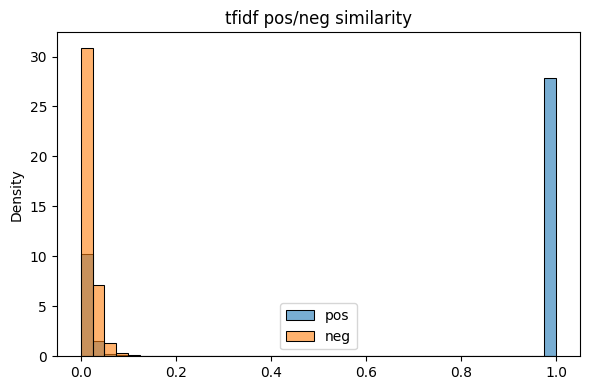

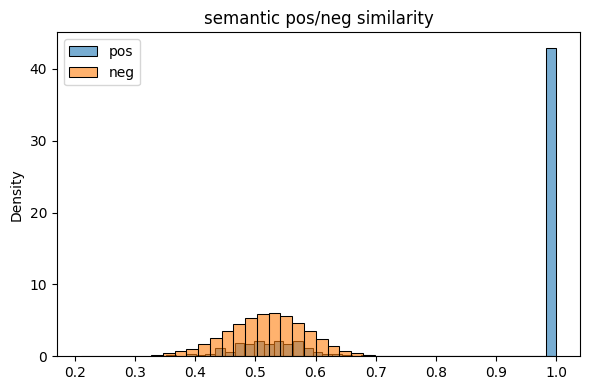

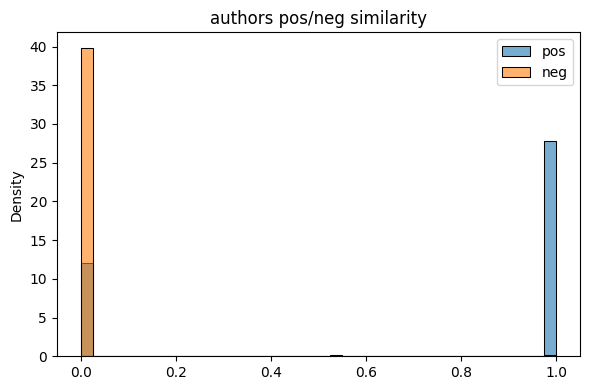

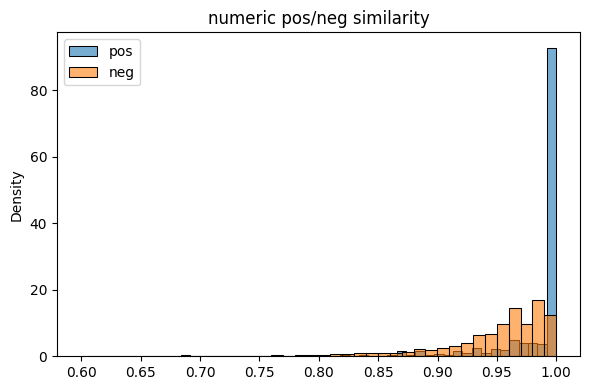

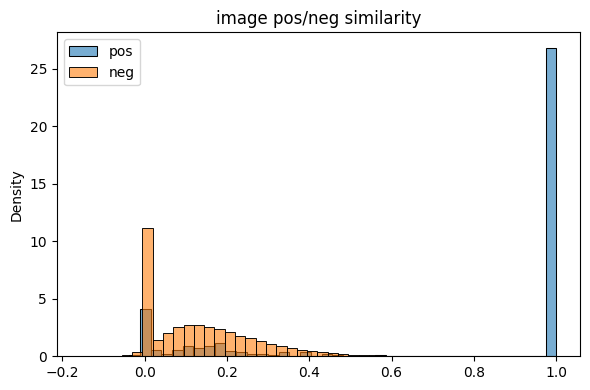

INSIGHT: tfidf=0.70, semantic=0.71, authors=0.70, numeric=0.70, image=0.72
INFO: all trucks have good separation between pos/neg pairs


In [11]:
same_desc = (filtered_df["desc_hash"].values[:,None] == filtered_df["desc_hash"].values[None,:])
pos_mask = same_desc
neg_mask = ~pos_mask

modalities = {
    "tfidf": X_tfidf_filtered,
    "semantic": Z_sem_filtered,
    "authors": X_auth_filtered,
    "numeric": X_num_filtered
}
if use_img:
    modalities["image"] = Z_img_filtered

sep = {}
for name, M in modalities.items():
    if hasattr(M, "toarray"):
        S = cosine_sim_csr(M).toarray()
    else:
        S = cosine_sim_dense(M, M)
    p = S[pos_mask]
    q = S[neg_mask]
    thr = np.percentile(q, 95)
    score = float((p > thr).mean()) if len(p)>0 and len(q)>0 else 0.5
    sep[name] = score
    plt.figure(figsize=(6,4)); sns.histplot(p, bins=40, stat="density", alpha=0.6, label="pos"); sns.histplot(q, bins=40, stat="density", alpha=0.6, label="neg"); plt.title(f"{name} pos/neg similarity"); plt.legend(); plt.tight_layout(); plt.show()

pd.DataFrame([sep]).to_csv(Path(ART, "posneg_separation.csv"), index=False)
print("INSIGHT: " + ", ".join([f"{k}={v:.2f}" for k,v in sep.items()]))

if len(sep) > 1:
    weak = [k for k,v in sep.items() if v < 0.5]
    if weak:
        print(f"WARNING: weak separation trucks: {', '.join(weak)}; consider adjusting fusion weights or thresholds to below 10%")
    else:
        print("INFO: all trucks have good separation between pos/neg pairs")

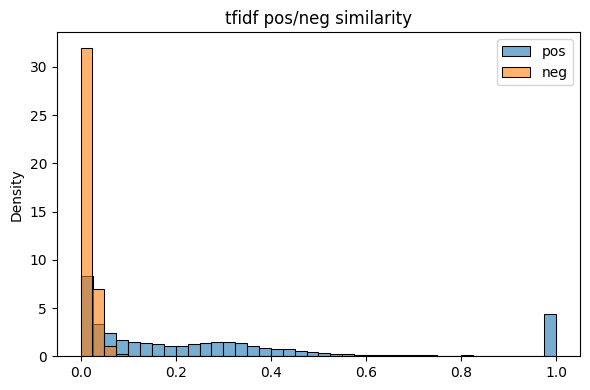

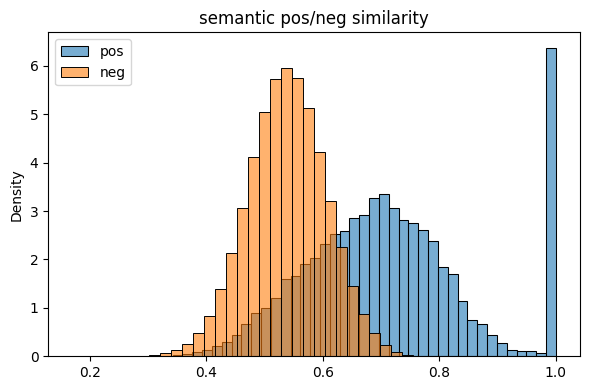

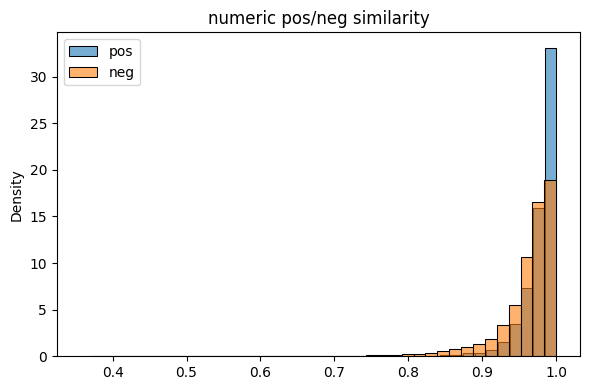

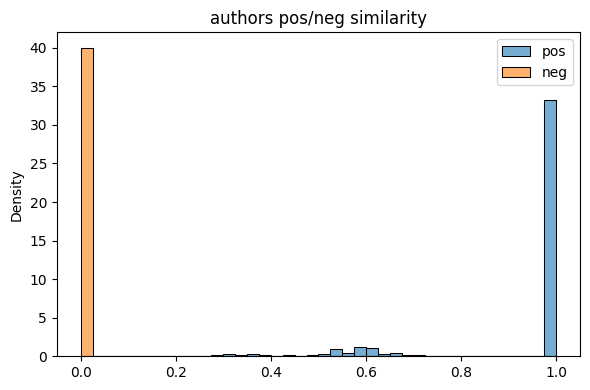

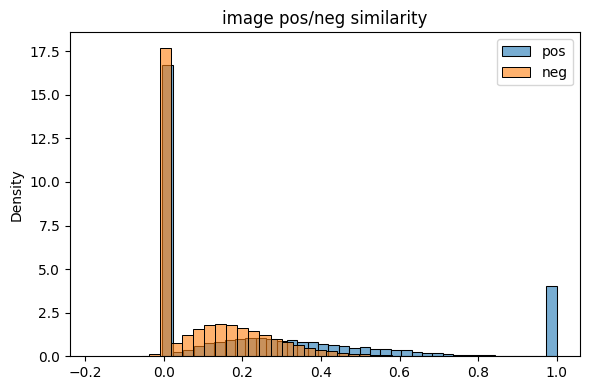

INSIGHT: tfidf=0.72, semantic=0.66, numeric=0.25, authors=1.00, image=0.29


In [12]:
main_author = df["author_list"].apply(lambda xs: xs[0].strip().lower() if isinstance(xs,list) and len(xs)>0 else "").values
same_author = (main_author[:,None] == main_author[None,:])
same_desc = df["desc_hash"].values[:, None] == df["desc_hash"].values[None, :]
pos_mask = same_desc | same_author
neg_mask = ~pos_mask

modalities = {
    "tfidf": X_tfidf,
    "semantic": Z_sem,
    "numeric": reps.X_num,
    "authors": X_auth
}
if use_img:
    modalities["image"] = reps.Z_img

sep = {}
for name, M in modalities.items():
    if hasattr(M, "toarray"):
        S = cosine_sim_csr(M).toarray()
    else:
        S = cosine_sim_dense(M, M)
    p = S[pos_mask]
    q = S[neg_mask]
    thr = np.percentile(q, 95)
    score = float((p > thr).mean()) if len(p)>0 and len(q)>0 else 0.5
    sep[name] = score
    plt.figure(figsize=(6,4)); sns.histplot(p, bins=40, stat="density", alpha=0.6, label="pos"); sns.histplot(q, bins=40, stat="density", alpha=0.6, label="neg"); plt.title(f"{name} pos/neg similarity"); plt.legend(); plt.tight_layout(); plt.show()

pd.DataFrame([sep]).to_csv(Path(ART, "posneg_separation.csv"), index=False)
print("INSIGHT: " + ", ".join([f"{k}={v:.2f}" for k,v in sep.items()]))
if len(sep) > 1:
    weak = [k for k,v in sep.items() if v < 0.5]
    if weak:
        print(f"WARNING: weak separation trucks: {', '.join(weak)}; consider adjusting fusion weights or thresholds to below 10%")
    else:
        print("INFO: all trucks have good separation between pos/neg pairs")

## Diversity checks: author HHI and year spread in top‑10

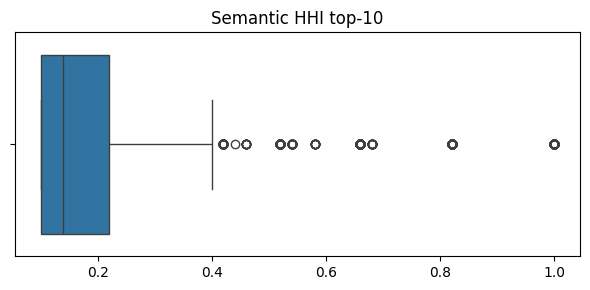

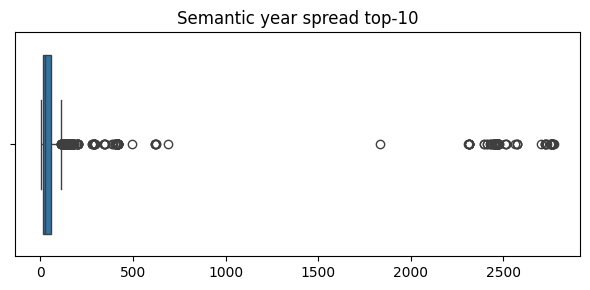

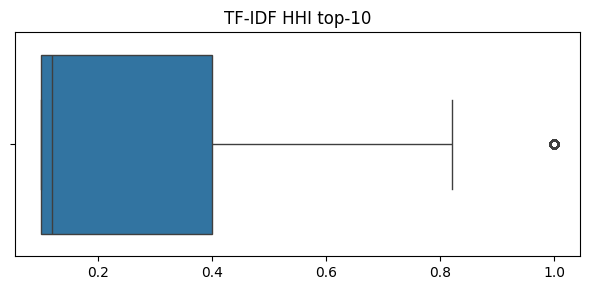

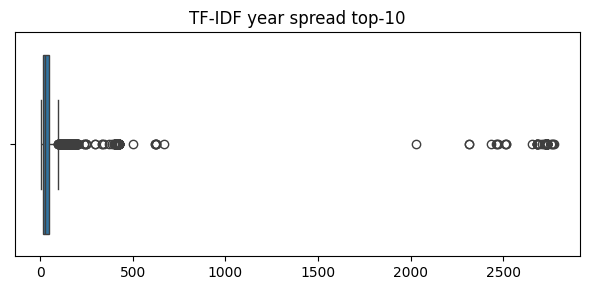

INSIGHT: semantic HHI med 0.14, Δyear med 27; tfidf HHI med 0.12, Δyear med 24
INFO: Semantic embeddings have good diversity (low HHI).
INFO: Semantic embeddings have good year spread (high temporal variety).
INFO: TF-IDF embeddings have good diversity (low HHI).
INFO: TF-IDF embeddings have good year spread (high temporal variety).


In [13]:
hhi_sem, spread_sem = diversity_check(cosine_sim_dense(reps.Z_sem, reps.Z_sem), df, k=10)
hhi_tfidf, spread_tfidf = diversity_check(cosine_sim_csr(X_tfidf).toarray(), df, k=10)

plt.figure(figsize=(6,3)); sns.boxplot(x=hhi_sem); plt.title("Semantic HHI top-10"); plt.tight_layout(); plt.show()
plt.figure(figsize=(6,3)); sns.boxplot(x=spread_sem); plt.title("Semantic year spread top-10"); plt.tight_layout(); plt.show()
plt.figure(figsize=(6,3)); sns.boxplot(x=hhi_tfidf); plt.title("TF-IDF HHI top-10"); plt.tight_layout(); plt.show()
plt.figure(figsize=(6,3)); sns.boxplot(x=spread_tfidf); plt.title("TF-IDF year spread top-10"); plt.tight_layout(); plt.show()

ins_div = f"semantic HHI med {np.median(hhi_sem):.2f}, Δyear med {np.median(spread_sem):.0f}; tfidf HHI med {np.median(hhi_tfidf):.2f}, Δyear med {np.median(spread_tfidf):.0f}"
print("INSIGHT: " + ins_div)

if np.median(hhi_sem) > 0.5:
    print("WARNING: Semantic embeddings have high HHI (low diversity). Recommendations may be dominated by a few authors.")
else:
    print("INFO: Semantic embeddings have good diversity (low HHI).")

if np.median(spread_sem) < 5:
    print("WARNING: Semantic embeddings have low year spread. Recommendations may lack temporal variety.")
else:
    print("INFO: Semantic embeddings have good year spread (high temporal variety).")

if np.median(hhi_tfidf) > 0.5:
    print("WARNING: TF-IDF embeddings have high HHI (low diversity). Recommendations may be dominated by a few authors.")
else:
    print("INFO: TF-IDF embeddings have good diversity (low HHI).")

if np.median(spread_tfidf) < 5:
    print("WARNING: TF-IDF embeddings have low year spread. Recommendations may lack temporal variety.")
else:
    print("INFO: TF-IDF embeddings have good year spread (high temporal variety).")

## Interpretability slices: 5 random + 5 outliers, per‑modality neighbors

In [14]:
rng = np.random.default_rng(123)
rand_ids = rng.choice(N, size=5, replace=False).tolist()
desc_len = df["description"].astype(str).map(lambda s: len(s.split()))
outliers = [int(desc_len.idxmin()), int(desc_len.idxmax())]
rare_author_idx = int(pd.Series([len(a) if isinstance(a,list) else 0 for a in df["author_list"]]).idxmin())
outliers.append(rare_author_idx)
if hasattr(reps, "img_mask") and np.any(reps.img_mask==0):
    outliers.append(int(np.where(reps.img_mask==0)[0][0]))
else:
    outliers.append(rand_ids[0])
year_num = pd.to_numeric(df["original_publication_year"], errors="coerce")
outliers.append(int(year_num.idxmin()))
seeds = list(dict.fromkeys(rand_ids + outliers))[:10]

ex_dir = Path(ART, "examples"); ex_dir.mkdir(parents=True, exist_ok=True)
for s in seeds:
    t_sem = nearest_table(reps.Z_sem, df, s, top=10); t_sem.to_csv(Path(ex_dir, f"{int(df.loc[s,'book_id'])}__semantic.csv"), index=False)
    t_tf = nearest_table(X_tfidf, df, s, top=10); t_tf.to_csv(Path(ex_dir, f"{int(df.loc[s,'book_id'])}__tfidf.csv"), index=False)
    t_au = nearest_table(X_auth, df, s, top=10); t_au.to_csv(Path(ex_dir, f"{int(df.loc[s,'book_id'])}__authors.csv"), index=False)
    t_nu = nearest_table(reps.X_num, df, s, top=10); t_nu.to_csv(Path(ex_dir, f"{int(df.loc[s,'book_id'])}__numeric.csv"), index=False)
    if use_img:
        t_im = nearest_table(reps.Z_img, df, s, top=10); t_im.to_csv(Path(ex_dir, f"{int(df.loc[s,'book_id'])}__image.csv"), index=False)
print(f"INSIGHT: saved interpretability tables for {len(seeds)} seeds")

INSIGHT: saved interpretability tables for 10 seeds


## Fusion readiness: scorecard and weight recommendations

In [15]:
weights_baseline = {"semantic":0.45, "tfidf":0.25, "authors":0.10, "numeric":0.10, "image":0.10}
agree_df = pd.read_csv(Path(ART, "modality_agreement.csv"))
sep_df = pd.read_csv(Path(ART, "posneg_separation.csv")).iloc[0].to_dict()
stab = {}
def resample_stability(track, k=100, trials=2, frac=0.5, seed=42):
    rng = np.random.default_rng(seed)
    base = topk_indices_from_track(track, k)
    scores = []
    n = track.shape[0]
    for _ in range(trials):
        mask = rng.random(n) < frac
        sub = track[mask]
        sub_idx = topk_indices_from_track(sub, k)
        map_back = np.where(mask)[0]
        reb = np.full_like(base, -1)
        for i in range(n):
            if mask[i]:
                sidx = np.where(map_back==i)[0]
                if len(sidx)==1:
                    reb[i,:] = map_back[sub_idx[sidx[0]]]
        ok = reb[:,0] >= 0
        scores.append(jaccard_at_k(base[ok,:10], reb[ok,:10]).mean() if ok.any() else 0.0)
    return float(np.mean(scores))

stab["semantic"] = resample_stability(Z_sem)
stab["tfidf"] = resample_stability(X_tfidf)
stab["authors"] = resample_stability(X_auth)
stab["numeric"] = resample_stability(reps.X_num)
if use_img:
    stab["image"] = resample_stability(reps.Z_img)

uniq = uniqueness_from_agreement(agree_df, anchor="semantic")
rec, scorecard = weight_scorecard(weights_baseline, stability=stab, separation=sep_df, uniqueness=uniq, include_image=use_img, image_cap=0.1, other_cap=0.50, w_stab=0.35, w_sep=0.6, w_uniq=0.05)
print(f"INSIGHT: recommended weights: {', '.join([f'{k}={v:.2f}' for k,v in rec.items()])}")
print(f"INSIGHT: stability: {', '.join([f'{k}={v:.2f}' for k,v in stab.items()])}")
print(f"INSIGHT: separation: {', '.join([f'{k}={v:.2f}' for k,v in sep_df.items()])}")
print(f"INSIGHT: uniqueness: {', '.join([f'{k}={v:.2f}' for k,v in uniq.items()])}")
print("INSIGHT: " + ", ".join([f"{k}: base={v:.2f} → rec={rec[k]:.2f}" for k,v in weights_baseline.items()]))
print(f"INSIGHT: scorecard:\n{scorecard}")
scorecard.to_csv(Path(ART, "weight_recommendations.csv"), index=False)
changes = deltas_over_threshold(scorecard, thr=0.05)
scorecard["recommended"].to_csv(Path(ART, "weight_recommendations.csv"), index=False, header=False)
if not changes.empty:
    print("INSIGHT: weight changes ≥0.05: " + " | ".join([f"{r.track}:{r.delta:+.2f}" for r in changes.itertuples()]))
else:
    print("INSIGHT: keep baseline weights; no change ≥0.05")
print("INSIGHT: " + " | ".join([f"{r.track}: base={r.baseline:.2f} → rec={r.recommended:.2f}" for r in scorecard.itertuples()]))

INFO:src.recsys.metrics:Track: authors | Baseline: 0.100 | Recommended: 0.253 | Stability: 0.236 | Separation: 1.000 | Uniqueness: 0.773
INFO:src.recsys.metrics:Track: image | Baseline: 0.100 | Recommended: 0.051 | Stability: 0.353 | Separation: 0.287 | Uniqueness: 0.965
INFO:src.recsys.metrics:Track: numeric | Baseline: 0.100 | Recommended: 0.190 | Stability: 0.501 | Separation: 0.251 | Uniqueness: 0.983
INFO:src.recsys.metrics:Track: semantic | Baseline: 0.450 | Recommended: 0.253 | Stability: 0.503 | Separation: 0.664 | Uniqueness: 0.000
INFO:src.recsys.metrics:Track: tfidf | Baseline: 0.250 | Recommended: 0.253 | Stability: 0.499 | Separation: 0.725 | Uniqueness: 0.686


INSIGHT: recommended weights: authors=0.25, image=0.05, numeric=0.19, semantic=0.25, tfidf=0.25
INSIGHT: stability: semantic=0.50, tfidf=0.50, authors=0.24, numeric=0.50, image=0.35
INSIGHT: separation: tfidf=0.72, semantic=0.66, numeric=0.25, authors=1.00, image=0.29
INSIGHT: uniqueness: tfidf=0.69, authors=0.77, numeric=0.98, image=0.97
INSIGHT: semantic: base=0.45 → rec=0.25, tfidf: base=0.25 → rec=0.25, authors: base=0.10 → rec=0.25, numeric: base=0.10 → rec=0.19, image: base=0.10 → rec=0.05
INSIGHT: scorecard:
      track  baseline  recommended  stability  separation  uniqueness  cap
0   authors      0.10     0.253175   0.235796    0.999731    0.772655  0.5
1     image      0.10     0.050635   0.352953    0.287350    0.965331  0.1
2   numeric      0.10     0.189840   0.500584    0.250924    0.983211  0.5
3  semantic      0.45     0.253175   0.503298    0.664240    0.000000  0.5
4     tfidf      0.25     0.253175   0.499161    0.724770    0.686401  0.5
INSIGHT: weight changes ≥0.05

## Save insights summary

In [16]:
lines = []
lines.append(f"non-EN {manifest['non_en_pct']:.1f}% | covers missing {manifest['covers_missing_pct']:.1f}% | image {manifest['image_enabled']}")
lines.append(Path(ART, "modality_agreement.csv").read_text(encoding="utf-8"))
lines.append(Path(ART, "posneg_separation.csv").read_text(encoding="utf-8"))
lines.append(Path(ART, "weight_recommendations.csv").read_text(encoding="utf-8"))
Path(ART, "insights.md").write_text("\n\n".join(lines), encoding="utf-8")
print("INSIGHT: saved insights to artifacts/eda2/insights.md")

INSIGHT: saved insights to artifacts/eda2/insights.md
